In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pointbiserialr
import numpy as np
import ast


import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
DATA_DIR = './library-data'

df = pd.read_csv(f'{DATA_DIR}/merged_processed.csv')
print(df.columns)
df.shape

Index(['checkout_id', 'customer_id', 'library_id', 'days_out_final', 'is_late',
       'book_title', 'book_authors', 'book_publisher', 'book_categories',
       'book_price', 'book_pages', 'book_age', 'book_age_category',
       'library_name', 'library_street_address', 'library_city',
       'library_region', 'library_postal_code', 'customer_name',
       'customer_street_address', 'customer_city', 'customer_state',
       'customer_zipcode', 'customer_occupation', 'customer_education',
       'customer_gender', 'customer_birth_date', 'customer_age',
       'customer_age_category'],
      dtype='object')


(1544, 29)

In [3]:
df.book_categories = df.book_categories.apply(ast.literal_eval)
df.book_authors = df.book_authors.apply(ast.literal_eval)

In [4]:
target = 'is_late'

y = df[target]

columns_to_drop = [target, 'days_out_final', 'checkout_id', 'customer_id', 'library_id']
X = df.drop(columns=columns_to_drop)

In [5]:
def plot_correlations(df, X, y, plot_title):

    corrs = {}
    for col in X.columns:
        if df[col].dtype == 'object' or df[col].nunique() < 10:
            encoded = LabelEncoder().fit_transform(df[col].astype(str))
            corrs[col] = pointbiserialr(y, encoded).correlation
        else:
            corrs[col] = pointbiserialr(y, df[col]).correlation

    corr_series = pd.Series(corrs).sort_values(key=np.abs, ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=corr_series.values, y=corr_series.index, orient='h')
    plt.title(plot_title)
    plt.tight_layout()

    plt.show()

/Users/milenadjordjevic/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
/Users/milenadjordjevic/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


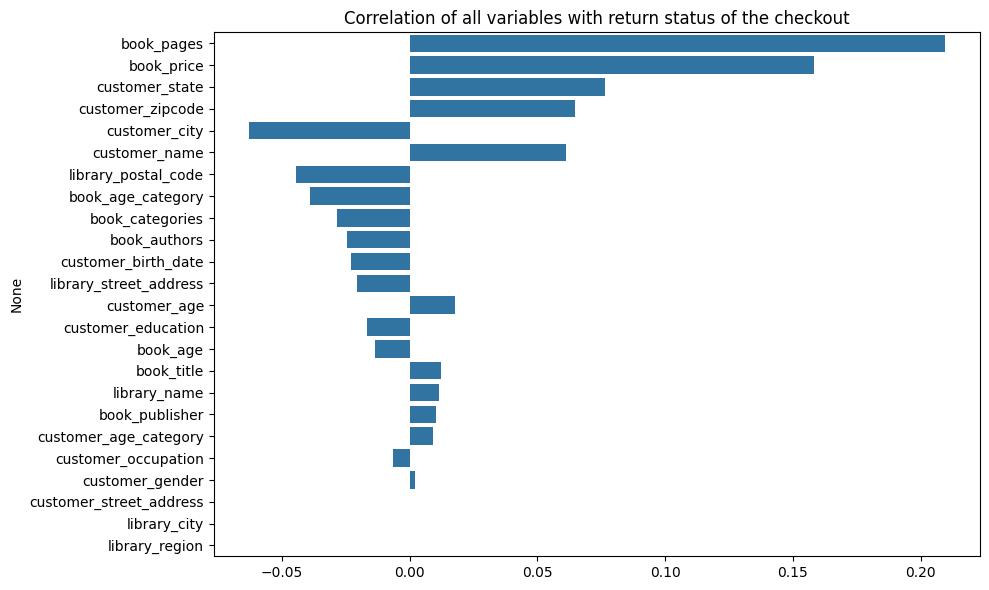

In [6]:
plot_correlations(df, X, y, plot_title="Correlation of all variables with return status of the checkout")

In [7]:
print(df.customer_state.unique())
print(df.customer_city.unique())
print(df.library_city.unique())

['Oregon' 'Unknown' 'Washington']
['Portland' 'Unknown' 'Oregon City' 'Beaverton' 'Lake Oswego' 'Vancouver'
 'Happy Valley' 'Tualatin' 'West Linn' 'Clackamas' 'Gresham' 'Damascus'
 'Gladstone']
['Portland']


In [8]:
# deriving new variable to calculate distances between cities

distance_from_portland = {
    'Portland': 0,
    'Unknown': -1,
    'Oregon City': 31,
    'Beaverton': 13,
    'Lake Oswego': 16,
    'Vancouver': 14,
    'Happy Valley': 21,
    'Tualatin': 21,
    'West Linn': 31,
    'Clackamas': 26,
    'Gresham': 27,
    'Damascus': 27,
    'Gladstone': 29
}

def compute_distance(row):
    a = distance_from_portland.get(row['customer_city'], -1)
    b = distance_from_portland.get(row['library_city'], -1)
    if a == -1 or b == -1:
        return -1
    return abs(a - b)

df['customer_library_distance'] = df.apply(compute_distance, axis=1)
df['customer_library_distance'].value_counts()

customer_library_distance
 0     1349
-1       77
 14      30
 21      26
 16      24
 13      20
 31      11
 27       4
 26       2
 29       1
Name: count, dtype: int64

In [9]:
target = 'is_late'

y = df[target]

columns_to_drop = [target, 'days_out_final', 'checkout_id', 'customer_id', 'library_id',
       'customer_street_address', 'customer_city',
       'customer_state', 'customer_zipcode', 'library_name', 'library_street_address',
       'library_city', 'library_region', 'library_postal_code',
       'customer_name']
X = df.drop(columns=columns_to_drop)

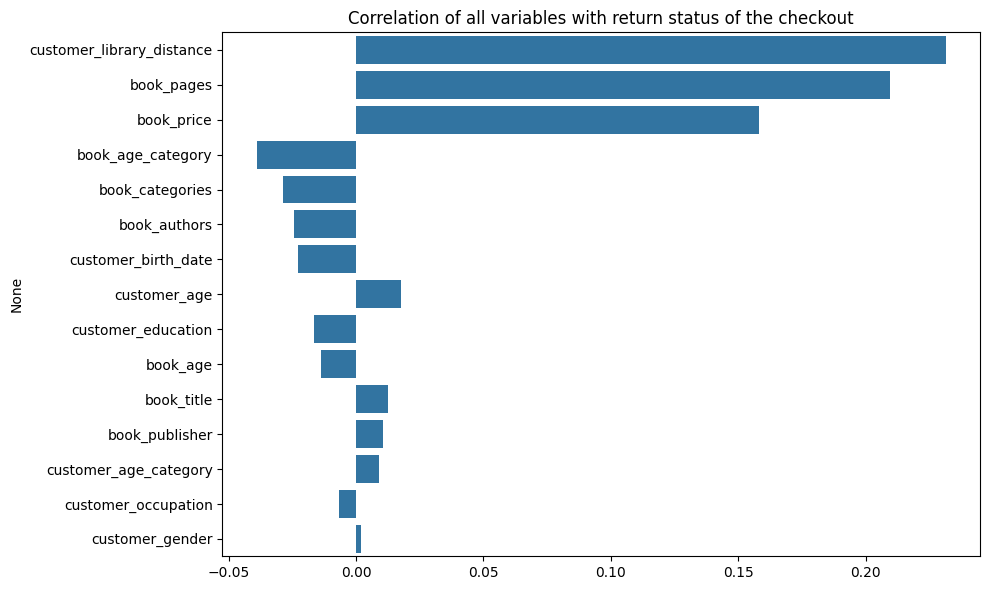

In [10]:
plot_correlations(df, X, y, plot_title="Correlation of all variables with return status of the checkout")

In [11]:
def compute_mutual_info(df, X, y, plot_title='Mutual Information Scores'):
    from sklearn.feature_selection import mutual_info_classif
    from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

    X_processed = pd.DataFrame(index=X.index)

    for col in X.columns:
        col_data = X[col]

        # Handle multi-label categorical stored as lists
        if isinstance(col_data.iloc[0], list):
            mlb = MultiLabelBinarizer()
            mlb_encoded = pd.DataFrame(mlb.fit_transform(col_data), 
                                       columns=[f"{col}_{cls}" for cls in mlb.classes_],
                                       index=X.index)
            X_processed = pd.concat([X_processed, mlb_encoded], axis=1)

        # Handle object or low-cardinality categorical (label encode)
        elif col_data.dtype == 'object' or df[col].nunique() < 10:
            encoded = LabelEncoder().fit_transform(col_data.astype(str))
            X_processed[col] = encoded

        # Numeric: leave as is
        else:
            X_processed[col] = col_data

    # Compute mutual information
    mi_scores = mutual_info_classif(X_processed, y, discrete_features='auto', random_state=42)
    mi_series = pd.Series(mi_scores, index=X_processed.columns).sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, max(6, len(mi_series) * 0.3)))
    sns.barplot(x=mi_series.values, y=mi_series.index, orient='h')
    plt.title(plot_title)
    plt.xlabel("Mutual Information Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return mi_series, X_processed


/var/folders/mn/wh8_vw8s4vx2lwxn82d99cnm0000gp/T/ipykernel_8716/4004201403.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


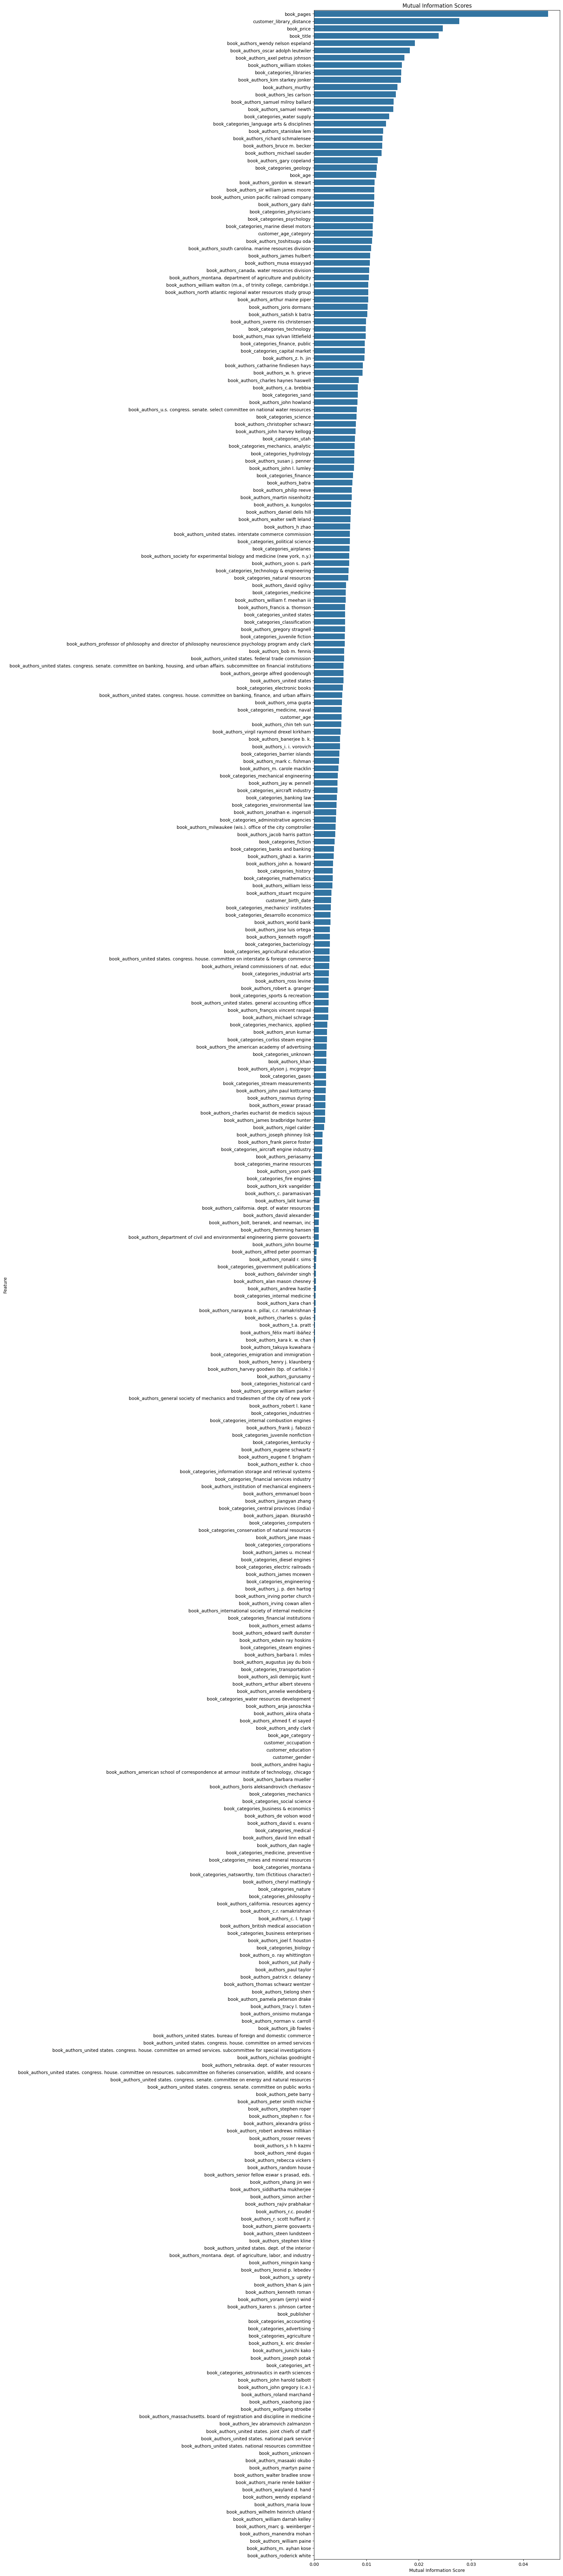

In [12]:
mi_series, X_processed = compute_mutual_info(df, X, y, plot_title='Mutual Information Scores')

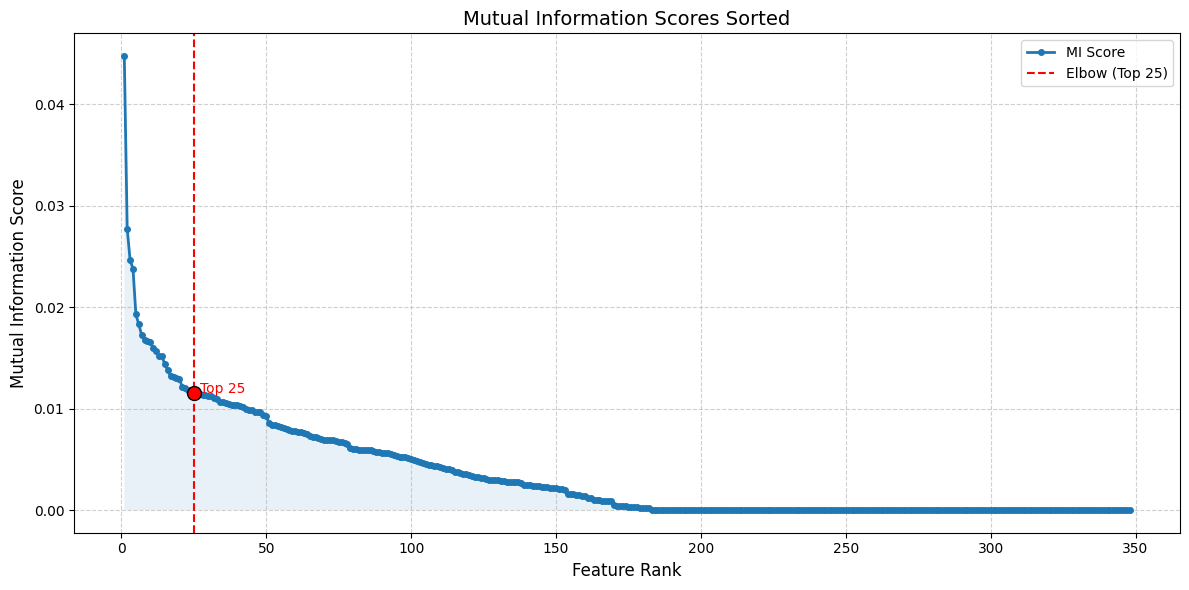

In [13]:
def plot_mi_elbow(mi_series, top_k=None, title="Mutual Information Scores Sorted"):

    scores = mi_series.values
    ranks = range(1, len(scores) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(ranks, scores, marker='o', linewidth=2, markersize=4, label='MI Score')
    plt.fill_between(ranks, scores, alpha=0.1)

    if top_k:
        plt.axvline(top_k, color='red', linestyle='--', linewidth=1.5, label=f'Elbow (Top {top_k})')
        plt.scatter(top_k, scores[top_k-1], color='red', s=100, edgecolors='black', zorder=5)
        plt.text(top_k + 2, scores[top_k-1], f"Top {top_k}", color='red', fontsize=10)

    plt.title(title, fontsize=14)
    plt.xlabel("Feature Rank", fontsize=12)
    plt.ylabel("Mutual Information Score", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_mi_elbow(mi_series, top_k=25)

In [14]:
top_k = mi_series.sort_values(ascending=False).head(25).index.tolist()
top_k

['book_pages',
 'customer_library_distance',
 'book_price',
 'book_title',
 'book_authors_wendy nelson espeland',
 'book_authors_oscar adolph leutwiler',
 'book_authors_axel petrus johnson',
 'book_authors_william stokes',
 'book_categories_libraries',
 'book_authors_kim starkey jonker',
 'book_authors_murthy',
 'book_authors_les carlson',
 'book_authors_samuel milroy ballard',
 'book_authors_samuel newth',
 'book_categories_water supply',
 'book_categories_language arts & disciplines',
 'book_authors_stanisław lem',
 'book_authors_richard schmalensee',
 'book_authors_bruce m. becker',
 'book_authors_michael sauder',
 'book_authors_gary copeland',
 'book_categories_geology',
 'book_age',
 'book_authors_gordon w. stewart',
 'book_authors_sir william james moore']

In [15]:
# valid frequency of such scor, this variable can have influence on the target value
df['book_authors'].explode().value_counts().loc['north atlantic regional water resources study group']

10

In [16]:
X_final = X_processed[top_k].copy()
final_df = pd.concat([X_final, y], axis=1)

In [18]:
final_df.to_csv(f"{DATA_DIR}/model_ready_dataset.csv", index=False)